#Barge Detection in the Amazon River

Harvard CS 288 Spring 2021  
Eric Lin, Julian Lee, Maggie Wang, and Sayak Maity  
Dr. Milind Tambe and Teaching Fellows 

In [ ]:
'''
Imports
'''
import torch
import torchvision
from torchvision import datasets, transforms
import math
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
import torchvision.models as models
import numpy as np
# CNN model imports
import torch.nn as nn

# optimizer
import torch.optim as optim

import copy

'''
Parameters
'''
classes = ('negative','positive')

# Connect to GDrive

In [ ]:
'''
Helpful for accessing datasets in google drive
'''

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
'''
  Navigate to the correct file path for images
'''
import os
print(os.getcwd())
# Eric filepath
# %cd "drive/.shortcut-targets-by-id/1S13RYrRLLEouppBjgNu5sSaSlLkN2pnL/Images/" 
%cd "drive/.shortcut-targets-by-id/1hsbfTMEcMwO8RawQqQ7tO43fdDHVIDkb/Implementation/"
! ls

/content
/content/drive/.shortcut-targets-by-id/1hsbfTMEcMwO8RawQqQ7tO43fdDHVIDkb/Implementation
288_barge_detection_cnn_v1.ipynb
288_contrastive_learning.ipynb
288_transfer_learning_barge_detection_eric_3.ipynb
288_transfer_learning_barge_detection_eric.ipynb
288_transfer_learning_barge_detection_julian.ipynb
apex
baseline_CNN_barge_detection.ipynb
datasets
graphs
masati_images
planet_images_png
runs
save
saved_models
sayak_test.ipynb
setup.sh
supContrast
test_images
tiff_to_png_script.ipynb
v2_288_transfer_learning_barge_detection_eric.ipynb
v3_288_transfer_learning_barge_detection_eric.ipynb


# Datasets  
Custom dataset [using PyTorch dataloader](https://colab.research.google.com/github/dthiagarajan/technical_blog/blob/master/_notebooks/2020-03-09-PyTorch-Dataset-and-DataLoaders.ipynb)  

In [ ]:
class CustomDataset(torch.utils.data.Dataset):
    """ You can define the __init__ function any way you like"""
    def __init__(self, examples, labels):
        self.examples = examples
        self.labels = labels

    """ This function signature always should take in 1 argument, corresponding to the index you're going to access.
        In this case, we're returning a tuple, corresponding to the training example and the corresponding label. 
        
        It will also be useful to convert the returned values to torch.Tensors, so we can push the data onto the
        GPU later on. Note how the label is put into an array, but the example isn't. This is just a convention:
        if we don't put `self.labels[index]` in a list, it'll just create a tensor of zeros with `self.labels[index]` zeros.
    """
    def __getitem__(self, index):
        return (torch.Tensor(self.examples[index]), torch.Tensor([self.labels[index]]))

    """ This function signature always should take in 0 arguments, and the output should be an `int`. """
    def __len__(self):
        return len(self.examples)

In [ ]:
# MASATI-v2 dataset (from Bing maps)
# Images are 512 x 512 pixels and resized to 224 x 224
# Relevant no boat labels: coast (1,132) and water (1,023)
# Relevant yes boat labels: coast_ship (1,038) and detail (1,789 zoomed in, grainier photos)

transform_rgb_224 = {
    'train': transforms.Compose([
      transforms.Resize((224,224)),           # resize to 224 x 224
      transforms.RandomHorizontalFlip(),      # random flip
      transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]),
    'val_test': transforms.Compose([          # no random flip
      transforms.Resize((224,224)),           # resize to 224 x 224
      transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
}

# Use ImageFolder since each class of images are stored in two different folders
no_boat_folder = 'masati_images/coast_water_combined'          # 2,154
yes_boat_folder = 'masati_images/positive_coast_ship_detail_combined'   # 2,826, 4,980 total
torch.manual_seed(288)
# Note: ImageFolder labels the folder that comes first alphabetically as label 0, 2nd as label 1, etc.
dataset_masati = datasets.ImageFolder(root='masati_images/', transform=transform_rgb_224['train'])
print("total length of dataset:", len(dataset_masati))
# Randomly split data with 80/10/10 splits
train_set_masati, val_set_masati, test_set_masati = torch.utils.data.random_split(dataset_masati, [math.floor(0.8*len(dataset_masati)), math.floor(0.1*len(dataset_masati)), math.floor(0.1*len(dataset_masati))])
print("train:", len(train_set_masati), "val:", len(val_set_masati), "test:", len(test_set_masati))
# Data loaders
trainloader_masati = torch.utils.data.DataLoader(train_set_masati, batch_size=64,
                                          shuffle=True, num_workers=0)
validloader_masati = torch.utils.data.DataLoader(val_set_masati, batch_size=64,
                                         shuffle=False, num_workers=0)
testloader_masati = torch.utils.data.DataLoader(test_set_masati, batch_size=64,
                                         shuffle=False, num_workers=0)

total length of dataset: 4980
train: 3984 val: 498 test: 498


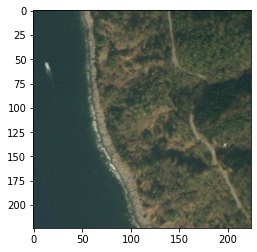

tensor(1)


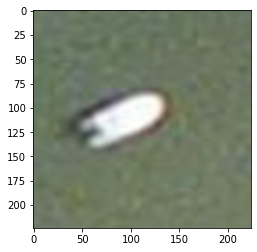

tensor(1)


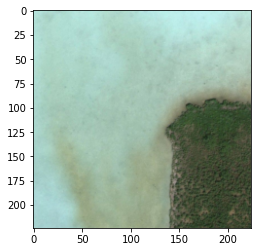

tensor(0)


In [ ]:
# Check and see images for datasets
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader_masati)
images, labels = dataiter.next()

for j in range(3):
  # show images
  imshow(images[j])
  # print labels
  print(labels[j])

# Train_val_test

In [ ]:
# Definitions for train, validate, and test
def validate(net, epoch, validloader):
    correct = 0
    total = 0
    net.eval()      # turn on eval mode

    with torch.no_grad():
        for (images, labels) in validloader:
            images, labels = images.cuda(), labels.cuda()
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    if epoch % 2 == 0:
      print('Epoch %d Validation accuracy: %d%%' % (
          epoch + 1, 100 * correct / total))
      
    return 100 * correct / total

def train(net, epochs, trainloader, validloader, optimizer, batch_size, validation=False, early_stopping = 20, transfer=True, positive_weight=1.0):
    best_accuracy = 0
    epochs_no_improve = 0

    for epoch in range(epochs):  # loop over the dataset multiple times
        criterion = nn.CrossEntropyLoss(weight = torch.Tensor([1.0, positive_weight]).cuda())
        net.train()     # turn on train mode after eval
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = inputs.cuda(), labels.cuda()

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()

            if i % 5 == 0:
                print('[Epoch %d, %2d] training loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 5))
                running_loss = 0.0 

        accuracy = validate(net, epoch, validloader)

        # if accuracy > best_accuracy:
        #     best_accuracy = accuracy
        #     if transfer:
        #       SAVE_PATH = './saved_models/resnet18-k-fold.pth'
        #     else:
        #       SAVE_PATH = './saved_models/resnet18-base.pth'
        #     state = {
        #         'epoch': epochs,
        #         'state_dict': net.state_dict(),
        #         'optimizer': optimizer.state_dict()
        #     }
        #     torch.save(state, SAVE_PATH)   # saves state dicts
        #     epochs_no_improve = 0 
        # else:
        #     epochs_no_improve += 1
        
        # if epochs_no_improve == early_stopping: 
        #     print('Early Stopping with', early_stopping, "epochs of no improvement. Best Accuracy:", best_accuracy)
        #     return 

    if transfer:
      SAVE_PATH = './saved_models/resnet18-k-fold.pth'
    else:
      SAVE_PATH = './saved_models/resnet18-base.pth'
    
    state = {
        'epoch': epochs,
        'state_dict': net.state_dict(),
        'optimizer': optimizer.state_dict()
    }
    torch.save(state, SAVE_PATH)  
    return 


def test(net, testloader, classes, batch_size):
    correct = 0
    total = 0
    
    class_correct = list(0. for i in range(len(classes)))
    class_total = list(0. for i in range(len(classes)))
    
    net.eval()
    
    with torch.no_grad():
        for (images, labels) in testloader:
            images, labels = images.cuda(), labels.cuda()
            outputs = net(images)
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Accuracy by class
            c = (predicted == labels).squeeze()
            for i in range(min(batch_size, len(labels))):
                label = labels[i]
                if min(batch_size, len(labels)) > 1:
                    class_correct[label] += c[i].item()
                else:
                    class_correct[label] += c
                class_total[label] += 1

    print('Overall Accuracy: %d%%' % (
        100 * correct / total))      
    # Accuracy for each class
    for i in range(2):
        print('Accuracy of %1s : %2d%%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))
    return {'negative': 100 * class_correct[0] / class_total[0], 'positive': 100 * class_correct[1] / class_total[1]}


# Base model for transfer learning

## v1 CNN model
Input: grayscale images 
Output: binary classification of barge detection  
Model: custom CNN  
Reference paper: "Ship classification and detection based on CNN"  

In [ ]:
# v1 CNN (custom) model
def conv_block(in_channels, out_channels, kernel_size=3, stride=1,
               padding=1):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding,
                  bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

class ConvNetV1(nn.Module):
    def __init__(self):
        super(ConvNetV1, self).__init__()
        self.model = nn.Sequential(
            conv_block(3, 32),                # rgb channel input
            conv_block(32, 32),
            conv_block(32, 64, stride=2),
            conv_block(64, 64),
            conv_block(64, 64),
            conv_block(64, 128, stride=2),
            conv_block(128, 128),
            conv_block(128, 256),
            conv_block(256, 256),
            nn.AdaptiveAvgPool2d(1)
        )
        # FC layer
        self.classifier = nn.Linear(256, len(classes))   # 256 in_features, binary output

    def forward(self, x):
        h = self.model(x)
        B, C, _, _ = h.shape
        h = h.view(B, C)
        return self.classifier(h)

In [ ]:
resnet18 = models.resnet18(pretrained=False)
resnet18.fc = nn.Linear(512, 2)
model = resnet18.cuda()

summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

## Train base model

In [ ]:
# Net
lr = 0.005
epochs = 3

# Loss function and optimizer
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)

In [ ]:
# Train
train(model, epochs, trainloader_masati, validloader_masati, optimizer, batch_size=64, validation=True, transfer=False)

[Epoch 1,  1] training loss: 0.165
[Epoch 1,  6] training loss: 1.938
[Epoch 1, 11] training loss: 1.135
[Epoch 1, 16] training loss: 0.828
[Epoch 1, 21] training loss: 0.688
[Epoch 1, 26] training loss: 0.763
[Epoch 1, 31] training loss: 0.709
[Epoch 1, 36] training loss: 0.705
[Epoch 1, 41] training loss: 0.663
[Epoch 1, 46] training loss: 0.684
[Epoch 1, 51] training loss: 0.641
[Epoch 1, 56] training loss: 0.695
[Epoch 1, 61] training loss: 0.654
Epoch 1 Validation accuracy: 63%
[Epoch 2,  1] training loss: 0.137
[Epoch 2,  6] training loss: 0.746
[Epoch 2, 11] training loss: 0.617
[Epoch 2, 16] training loss: 0.703
[Epoch 2, 21] training loss: 0.652
[Epoch 2, 26] training loss: 0.618
[Epoch 2, 31] training loss: 0.613
[Epoch 2, 36] training loss: 0.597
[Epoch 2, 41] training loss: 0.620
[Epoch 2, 46] training loss: 0.536
[Epoch 2, 51] training loss: 0.453
[Epoch 2, 56] training loss: 0.621
[Epoch 2, 61] training loss: 0.584
Epoch 2 Validation accuracy: 70%
[Epoch 3,  1] training l

In [ ]:
# Torch summary
writer = SummaryWriter()

images, labels = next(iter(trainloader))

grid = torchvision.utils.make_grid(images)
writer.add_image('images', grid, 0)
writer.add_graph(net, images.cuda())
writer.close()



In [ ]:
# Tensorboard
# https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/tensorboard_with_pytorch.ipynb
! pip install tensorboard
tensorboard --logdir=runs


SyntaxError: ignored

In [ ]:
# Test
test(model, testloader_masati, classes, batch_size)

Accuracy on test images: 76%
Accuracy of negative : 66%
Accuracy of positive : 83%


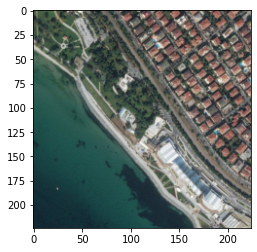

Ground truth: positive	Prediction: negative


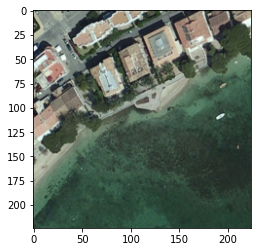

Ground truth: positive	Prediction: negative


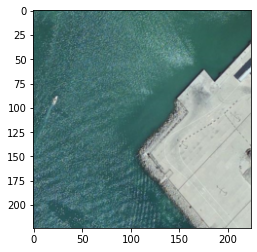

Ground truth: positive	Prediction: negative


In [ ]:
# Show test images
dataiter = iter(testloader)
images, labels = dataiter.next()
outputs = net(images.cuda())
_, predicted = torch.max(outputs, 1)

# print images
for i in range(3,6):
    imshow(images[i])
    print('Ground truth:', classes[labels[i]], end='\t')
    print('Prediction:', classes[predicted[i]])

# Save model

In [ ]:
# Visualize model structure
from torchsummary import summary

input_shape = (3,224,224)
summary(net.cuda(), input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [ ]:
SAVE_PATH = './saved_models/resnet18-trial-2.pth'
state = {
    'epoch': epochs,
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict()
}
torch.save(state, SAVE_PATH)   # saves state dicts
# torch.save(net, SAVE_PATH)                  # saves whole model

# New data for transfer learning

In [ ]:
# Planet lab dataset (self curated)
# Images are 224 x 224 pixels
# Relevant no boat labels: 
# Relevant yes boat labels: 

transform_rgb_224 = {
    'train': transforms.Compose([
      transforms.RandomCrop((224,224)),       
      transforms.RandomHorizontalFlip(),      
      transforms.RandomVerticalFlip(),
      transforms.ColorJitter(brightness =(0.85, 1.15), contrast=(0.85, 1.15), saturation=(0.85, 1.15), hue=0.1),
      transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]),
    'val_test': transforms.Compose([          # no random flip
      transforms.Resize((224)),               # resize to 256
      transforms.CenterCrop(224),       # random crop to (224, 224)
      transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
}

# Use ImageFolder since each class of images are stored in two different folders
no_boat_folder = './planet_images_png/negative_png'          # 100 total
yes_boat_folder = './planet_images_png/positive_png'         # 100 total
dataset_planet = datasets.ImageFolder(root='planet_images_png/')
print("total length of dataset:", len(dataset_planet))

class MyLazyDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        if self.transform:
            if self.dataset[index][0].size[0] < 224 or self.dataset[index][0].size[1] < 224:
                x = self.transform(transforms.Resize(224)(self.dataset[index][0]))
            else:
                x = self.transform(self.dataset[index][0])
        else:
            x = self.dataset[index][0]
        y = self.dataset[index][1]
        return x, y
    
    def __len__(self):
        return len(self.dataset)

traindataset = MyLazyDataset(dataset=dataset_planet,transform=transform_rgb_224['train'])
validdataset = MyLazyDataset(dataset=dataset_planet, transform=transform_rgb_224['val_test'])
testdataset = MyLazyDataset(dataset=dataset_planet, transform=transform_rgb_224['val_test'])

total length of dataset: 296


# Transfer Learning  
[Pytorch documentation](https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html)

In [ ]:
from sklearn.model_selection import StratifiedKFold, train_test_split

def kFoldCV(k=5, epochs=12, lr=0.0002, positive_weight=1.0):
  print(positive_weight)
  LOAD_PATH_BASE = './saved_models/resnet18-base.pth'
  saved_state_base = torch.load(LOAD_PATH_BASE)

  # Create the index splits for training, validation and test
  targets = np.array(dataset_planet.targets)
  indices = np.arange(len(targets))
  trainval_index, test_index = train_test_split(
    indices,
    test_size= 1 / k,
    shuffle=True,
    stratify=targets,
    random_state=288)

  test_set_planet = torch.utils.data.Subset(testdataset, indices=test_index)
  testloader_planet = torch.utils.data.DataLoader(test_set_planet, batch_size=16,
                                        shuffle=True, num_workers=0, drop_last=False)

  skf = StratifiedKFold(n_splits = k - 1, shuffle=True, random_state=288)
  
  negatives = []
  positives = []

  for train_index, val_index in skf.split(trainval_index, targets[trainval_index]):
  
    train_set_planet = torch.utils.data.Subset(traindataset, indices=trainval_index[train_index])
    valid_set_planet = torch.utils.data.Subset(validdataset, indices=trainval_index[val_index])  

    trainloader_planet = torch.utils.data.DataLoader(train_set_planet, batch_size=16,
                                              shuffle=True, num_workers=0, drop_last=False)
    validloader_planet = torch.utils.data.DataLoader(valid_set_planet, batch_size=16,
                                              shuffle=True, num_workers=0, drop_last=False)

    print('Train:', len(train_set_planet), 'Validation:', len(valid_set_planet), 'Test:', len(test_set_planet))
    
  
    base_model = models.resnet18()
    base_model.fc = nn.Linear(512, 2)

    base_model.load_state_dict(saved_state_base['state_dict'])
    base_model = base_model.cuda()
    test(base_model, trainloader_planet, classes, batch_size)

    print('Pre Fine-Tuning Metrics')
    print('Train:')
    test(base_model, trainloader_planet, classes, batch_size)
    print('Validation:')
    test(base_model, validloader_planet, classes, batch_size)
    # print('Test:')    
    # test(base_model, testloader_planet, classes, batch_size)
    
    for param in base_model.parameters():
      param.requires_grad = False
        
    for param in base_model.layer4[1].conv2.parameters():
      param.requires_grad = True

    for param in base_model.layer4[1].bn2.parameters():
      param.requires_grad = True

    for param in base_model.fc.parameters():
      param.requires_grad = True

    # Train on new dataset
    '''
    Parameters
    '''
    optimizer = optim.Adam( 
        [{'params': base_model.fc.parameters(), 'lr': lr},
        {'params': base_model.layer4[1].bn2.parameters(), 'lr':lr/5},
        {'params': base_model.layer4[1].conv2.parameters(), 'lr': lr/5}], lr=0)
    train(base_model, epochs=epochs, trainloader=trainloader_planet, validloader=validloader_planet, optimizer=optimizer, batch_size=batch_size, validation=True, early_stopping = 51, transfer=True, positive_weight=positive_weight)
    
    # Test accuracy AFTER transfer learning
    LOAD_PATH_TRAINED = './saved_models/resnet18-k-fold.pth'
    saved_state_trained = torch.load(LOAD_PATH_TRAINED)
    base_model = models.resnet18()
    base_model.fc = nn.Linear(512, 2)
    base_model.load_state_dict(saved_state_trained['state_dict'])
    base_model = base_model.cuda()


    print('Post Fine-Tuning Metrics')
    print('Train:')
    test(base_model, trainloader_planet, classes, batch_size)
    print('Validation:')
    stats = test(base_model, validloader_planet, classes, batch_size)
    negatives.append(stats['negative'])
    positives.append(stats['positive'])
  print('Avg Negative', sum(negatives) / len(negatives), 'Avg Positive', sum(positives) / len(positives))


In [ ]:
from sklearn.model_selection import StratifiedKFold, train_test_split

def train_test(epochs=15, lr=0.005, positive_weight=1.0):
  print(positive_weight)
  LOAD_PATH_BASE = './saved_models/resnet18-base.pth'
  saved_state_base = torch.load(LOAD_PATH_BASE)

  # Create the index splits for training, validation and test
  targets = np.array(dataset_planet.targets)
  indices = np.arange(len(targets))
  
  trainval_index, test_index = train_test_split(
    indices,
    test_size= 1/5,
    shuffle=True,
    stratify=targets,
    random_state=288)

  test_set_planet = torch.utils.data.Subset(testdataset, indices=test_index)
  testloader_planet = torch.utils.data.DataLoader(test_set_planet, batch_size=16,
                                        shuffle=False, num_workers=0, drop_last=False)

  train_set_planet = torch.utils.data.Subset(traindataset, indices=trainval_index)
  trainloader_planet = torch.utils.data.DataLoader(train_set_planet, batch_size=16,
                                            shuffle=False, num_workers=0, drop_last=False)
  print('Train:', len(train_set_planet), 'Test:', len(test_set_planet))
  
  base_model = models.resnet18()
  base_model.fc = nn.Linear(512, 2)

  # base_model.load_state_dict(saved_state_base['state_dict'])
  base_model = base_model.cuda()

  print('Pre Fine-Tuning Metrics')
  
  print('Train:')
  test(base_model, trainloader_planet, classes, batch_size=16)

  # print('Test:')    
  # test(base_model, testloader_planet, classes, batch_size)
  
  for param in base_model.parameters():
    param.requires_grad = False
      
  for param in base_model.layer4[1].conv2.parameters():
    param.requires_grad = True

  for param in base_model.layer4[1].bn2.parameters():
    param.requires_grad = True

  for param in base_model.fc.parameters():
    param.requires_grad = True

  # Train on new dataset
  '''
  Parameters
  '''
  optimizer = optim.Adam( 
      [{'params': base_model.fc.parameters(), 'lr': lr},
      {'params': base_model.layer4[1].bn2.parameters(), 'lr':lr/5},
      {'params': base_model.layer4[1].conv2.parameters(), 'lr': lr/5}], lr=0)
  train(base_model, epochs=epochs, trainloader=trainloader_planet, validloader=testloader_planet, optimizer=optimizer, batch_size=16, validation=True, early_stopping = 51, transfer=True, positive_weight=positive_weight)
  
  # Test accuracy AFTER transfer learning
  LOAD_PATH_TRAINED = './saved_models/resnet18-k-fold.pth'
  saved_state_trained = torch.load(LOAD_PATH_TRAINED)
  base_model = models.resnet18()
  base_model.fc = nn.Linear(512, 2)
  base_model.load_state_dict(saved_state_trained['state_dict'])
  base_model = base_model.cuda()


  print('Post Fine-Tuning Metrics')
  print('Train:')
  test(base_model, trainloader_planet, classes, batch_size=16)
  print('Test:')
  stats = test(base_model, testloader_planet, classes, batch_size=16)
 

In [ ]:
for weight in [1.75, 2]:
  kFoldCV(positive_weight=weight)

1.75
Train: 177 Validation: 59 Test: 60
Overall Accuracy: 68%
Accuracy of negative : 67%
Accuracy of positive : 70%
Pre Fine-Tuning Metrics
Train:
Overall Accuracy: 71%
Accuracy of negative : 71%
Accuracy of positive : 72%
Validation:
Overall Accuracy: 62%
Accuracy of negative : 53%
Accuracy of positive : 80%
[Epoch 1,  1] training loss: 0.198
[Epoch 1,  6] training loss: 0.968
[Epoch 1, 11] training loss: 0.892
Epoch 1 Validation accuracy: 66%
[Epoch 2,  1] training loss: 0.157
[Epoch 2,  6] training loss: 0.680
[Epoch 2, 11] training loss: 0.969
[Epoch 3,  1] training loss: 0.152
[Epoch 3,  6] training loss: 0.675
[Epoch 3, 11] training loss: 0.657
Epoch 3 Validation accuracy: 67%
[Epoch 4,  1] training loss: 0.123
[Epoch 4,  6] training loss: 0.678
[Epoch 4, 11] training loss: 0.590
[Epoch 5,  1] training loss: 0.102
[Epoch 5,  6] training loss: 0.605
[Epoch 5, 11] training loss: 0.639
Epoch 5 Validation accuracy: 74%
[Epoch 6,  1] training loss: 0.124
[Epoch 6,  6] training loss: 0

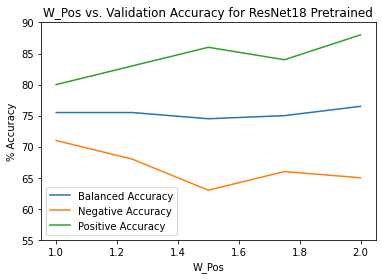

In [ ]:
import matplotlib.pyplot as plt
x = [1, 1.25, 1.5, 1.75, 2]
plt.plot(x, [75.5, 75.5, 74.5, 75, 76.5], label = 'Balanced Accuracy')
plt.plot(x, [71, 68, 63, 66, 65], label = 'Negative Accuracy')
plt.plot(x, [80, 83, 86, 84, 88], label = 'Positive Accuracy')
plt.legend(loc='best')
plt.xlabel('W_Pos')
plt.ylabel('% Accuracy')
plt.ylim(55, 90)
plt.title('W_Pos vs. Validation Accuracy for ResNet18 Pretrained')
plt.show()

In [ ]:
train_test(positive_weight=1.25)

1.25
Train: 236 Test: 60
Pre Fine-Tuning Metrics
Train:
Overall Accuracy: 34%
Accuracy of negative :  0%
Accuracy of positive : 100%
[Epoch 1,  1] training loss: 0.153
[Epoch 1,  6] training loss: 1.023
[Epoch 1, 11] training loss: 0.615
Epoch 1 Validation accuracy: 66%
[Epoch 2,  1] training loss: 0.118
[Epoch 2,  6] training loss: 0.660
[Epoch 2, 11] training loss: 0.456
[Epoch 3,  1] training loss: 0.112
[Epoch 3,  6] training loss: 0.537
[Epoch 3, 11] training loss: 0.483
Epoch 3 Validation accuracy: 75%
[Epoch 4,  1] training loss: 0.103
[Epoch 4,  6] training loss: 0.498
[Epoch 4, 11] training loss: 0.385
[Epoch 5,  1] training loss: 0.093
[Epoch 5,  6] training loss: 0.502
[Epoch 5, 11] training loss: 0.429
Epoch 5 Validation accuracy: 78%
[Epoch 6,  1] training loss: 0.057
[Epoch 6,  6] training loss: 0.470
[Epoch 6, 11] training loss: 0.388
[Epoch 7,  1] training loss: 0.077
[Epoch 7,  6] training loss: 0.552
[Epoch 7, 11] training loss: 0.313
Epoch 7 Validation accuracy: 76%


NameError: ignored

In [ ]:

# Check and see images for datasets
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
# get some random training images


tensor([1, 1, 0, 1, 1, 1, 1, 1], device='cuda:0') tensor([1, 1, 0, 1, 1, 0, 0, 1])


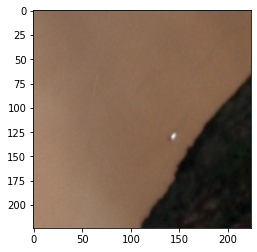

Ground truth: positive	Prediction: positive


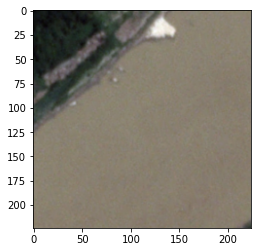

Ground truth: positive	Prediction: positive


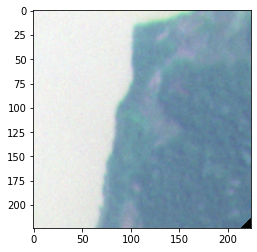

Ground truth: negative	Prediction: negative


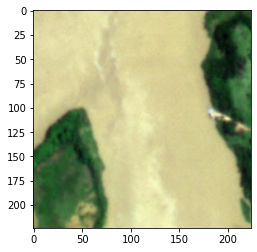

Ground truth: positive	Prediction: positive


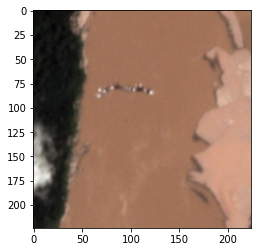

Ground truth: positive	Prediction: positive


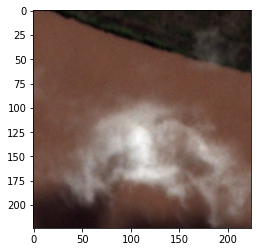

Ground truth: negative	Prediction: positive


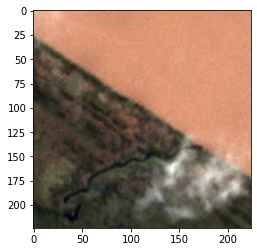

Ground truth: negative	Prediction: positive


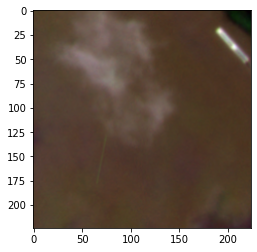

Ground truth: positive	Prediction: positive
tensor([1, 0, 0, 0, 0, 1, 0, 0], device='cuda:0') tensor([1, 0, 0, 0, 0, 1, 0, 0])


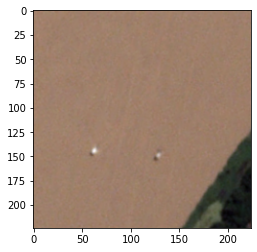

Ground truth: positive	Prediction: positive


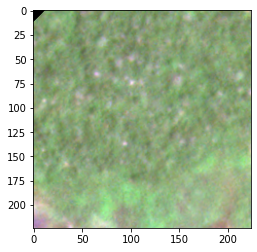

Ground truth: negative	Prediction: negative


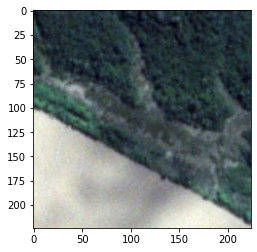

Ground truth: negative	Prediction: negative


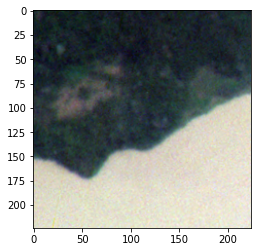

Ground truth: negative	Prediction: negative


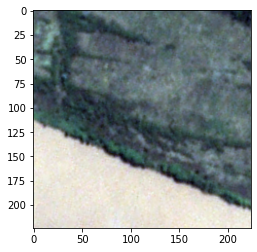

Ground truth: negative	Prediction: negative


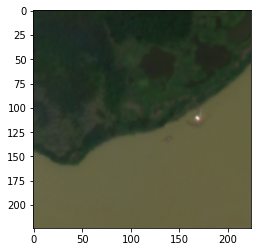

Ground truth: positive	Prediction: positive


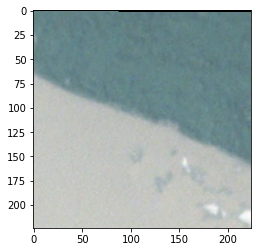

Ground truth: negative	Prediction: negative


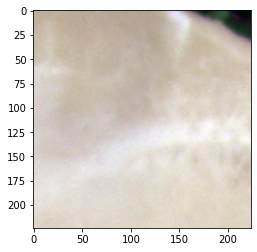

Ground truth: negative	Prediction: negative
tensor([1, 1, 0, 0, 0, 0, 0, 0], device='cuda:0') tensor([1, 1, 0, 0, 0, 0, 0, 0])


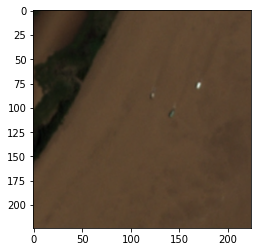

Ground truth: positive	Prediction: positive


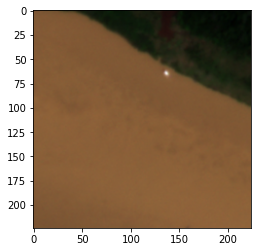

Ground truth: positive	Prediction: positive


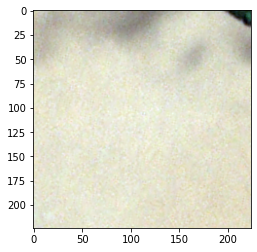

Ground truth: negative	Prediction: negative


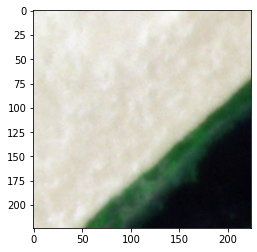

Ground truth: negative	Prediction: negative


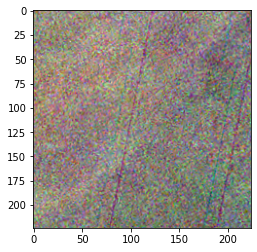

Ground truth: negative	Prediction: negative


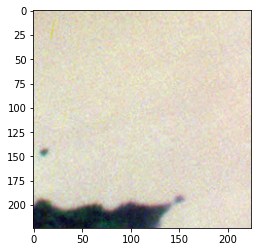

Ground truth: negative	Prediction: negative


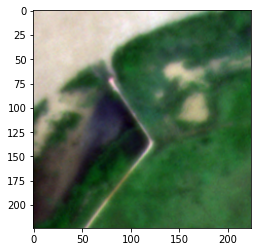

Ground truth: negative	Prediction: negative


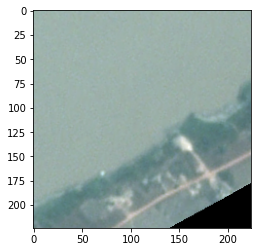

Ground truth: negative	Prediction: negative
tensor([0, 1, 0, 0, 1, 0, 1, 1], device='cuda:0') tensor([0, 1, 0, 1, 1, 0, 1, 1])


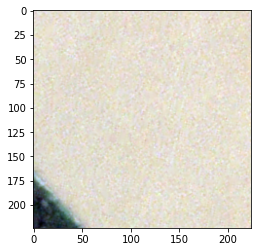

Ground truth: negative	Prediction: negative


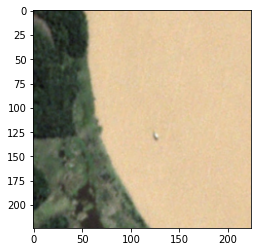

Ground truth: positive	Prediction: positive


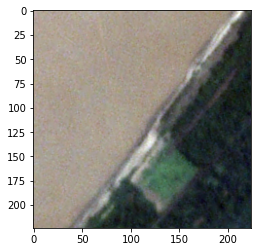

Ground truth: negative	Prediction: negative


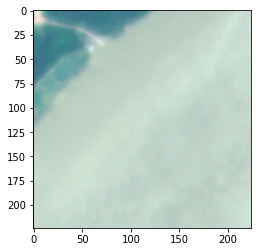

Ground truth: positive	Prediction: negative


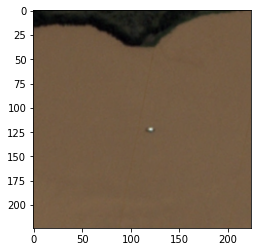

Ground truth: positive	Prediction: positive


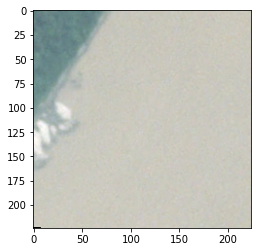

Ground truth: negative	Prediction: negative


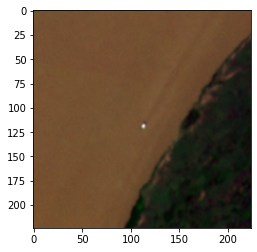

Ground truth: positive	Prediction: positive


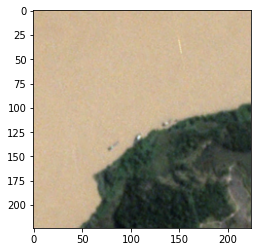

Ground truth: positive	Prediction: positive
tensor([1, 1, 1, 0, 0, 0, 0, 0], device='cuda:0') tensor([1, 1, 1, 1, 1, 1, 0, 0])


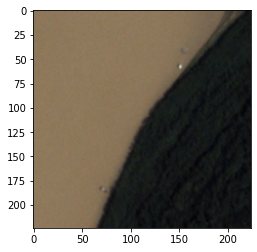

Ground truth: positive	Prediction: positive


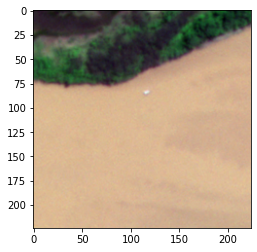

Ground truth: positive	Prediction: positive


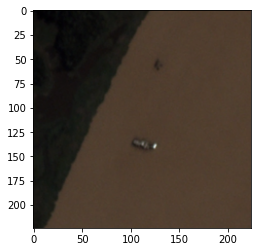

Ground truth: positive	Prediction: positive


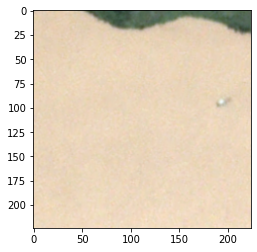

Ground truth: positive	Prediction: negative


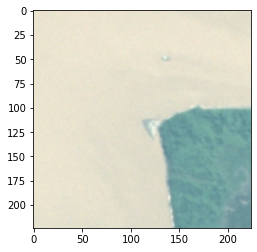

Ground truth: positive	Prediction: negative


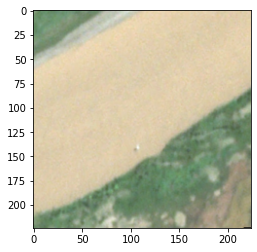

Ground truth: positive	Prediction: negative


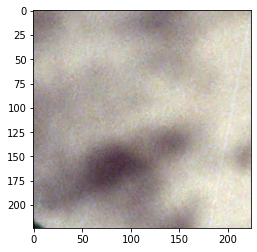

Ground truth: negative	Prediction: negative


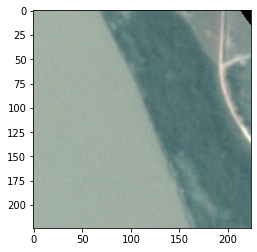

Ground truth: negative	Prediction: negative


In [ ]:
# Show test images
dataiter = iter(testloader_planet)

# print images:
for _ in range(5):
  images, labels = dataiter.next()
  outputs = base_model(images.cuda())
  _, predicted = torch.max(outputs, 1)
  print(predicted, labels)
  for i in range(8):
      imshow(images[i])
      print('Ground truth:', classes[labels[i]], end='\t')
      print('Prediction:', classes[predicted[i]])
  


# Save transfer learned model

In [ ]:
# Visualize model structure
from torchsummary import summary

input_shape = (3,224,224)
summary(new_model.cuda(), input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             864
       BatchNorm2d-2         [-1, 32, 224, 224]              64
              ReLU-3         [-1, 32, 224, 224]               0
            Conv2d-4         [-1, 32, 224, 224]           9,216
       BatchNorm2d-5         [-1, 32, 224, 224]              64
              ReLU-6         [-1, 32, 224, 224]               0
            Conv2d-7         [-1, 64, 112, 112]          18,432
       BatchNorm2d-8         [-1, 64, 112, 112]             128
              ReLU-9         [-1, 64, 112, 112]               0
           Conv2d-10         [-1, 64, 112, 112]          36,864
      BatchNorm2d-11         [-1, 64, 112, 112]             128
             ReLU-12         [-1, 64, 112, 112]               0
           Conv2d-13         [-1, 64, 112, 112]          36,864
      BatchNorm2d-14         [-1, 64, 1

In [ ]:
SAVE_PATH = './saved_models/transfer_learned_cnn_v2.pth'
state = {
    'epoch': epochs,
    'state_dict': net.state_dict(),
    'optimizer': optimizer.state_dict()
}
torch.save(state, SAVE_PATH)   # saves state dicts
# torch.save(net, SAVE_PATH)                  # saves whole model